In [56]:
from numba import njit, prange
import numpy as np
from pathlib import Path
from PIL import Image
import scipy.stats
import matplotlib.pyplot as plt

obj_fn = Path("Datsun_280Z.obj")
vertices = np.array([[float(x) for x in line.split()[1:]] for line in obj_fn.read_text().split("\n") if line.startswith("v ")])
vertices

array([[ 0.70074 ,  0.136954,  0.669096],
       [ 0.695587,  0.097424,  0.664041],
       [ 0.705866,  0.176315,  0.674631],
       ...,
       [-0.609475,  0.265177, -0.900921],
       [-0.608976,  0.276609, -0.907037],
       [-0.61058 ,  0.239872, -0.895883]])

In [34]:
vertices.shape

(59108, 3)

In [35]:
vertices.dtype

dtype('float64')

In [36]:
vertices.max(axis=0)

array([0.854326, 0.995499, 1.902197])

In [37]:
vertices.min(axis=0)

array([-0.854331, -0.032241, -1.714781])

In [38]:
vertices.mean(axis=0)

array([-0.00332169,  0.43362014, -0.09174528])

In [39]:
scipy.stats.describe(vertices, axis=0)

DescribeResult(nobs=59108, minmax=(array([-0.854331, -0.032241, -1.714781]), array([0.854326, 0.995499, 1.902197])), mean=array([-0.00332169,  0.43362014, -0.09174528]), variance=array([0.30280144, 0.05516835, 1.14500536]), skewness=array([0.0150603 , 0.22409571, 0.08586237]), kurtosis=array([-1.73674995, -0.97352434, -1.3919367 ]))

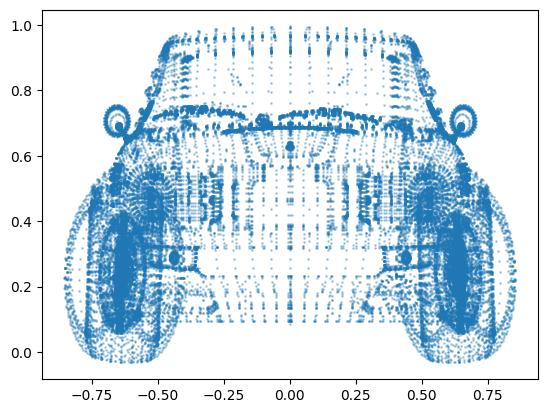

In [40]:
plt.scatter(vertices[:,0], vertices[:,1], alpha=0.3, s=1)

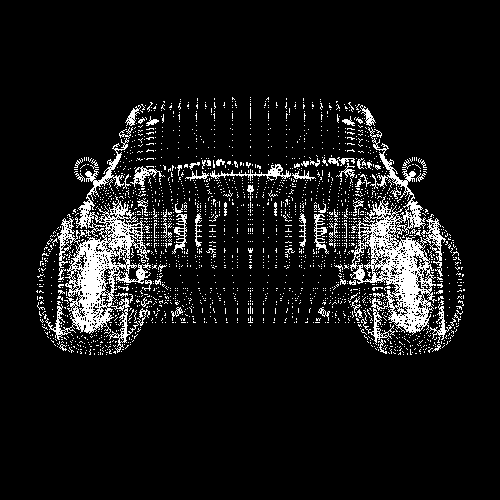

In [41]:
projected_xy = (vertices[:, :2] * 250).round().astype(int)
projected_xy = np.array([250, 346]) - projected_xy
imga = np.zeros((500, 500), dtype=np.uint8)
imga[projected_xy[:, 1], projected_xy[:, 0]] = 255
Image.fromarray(imga)

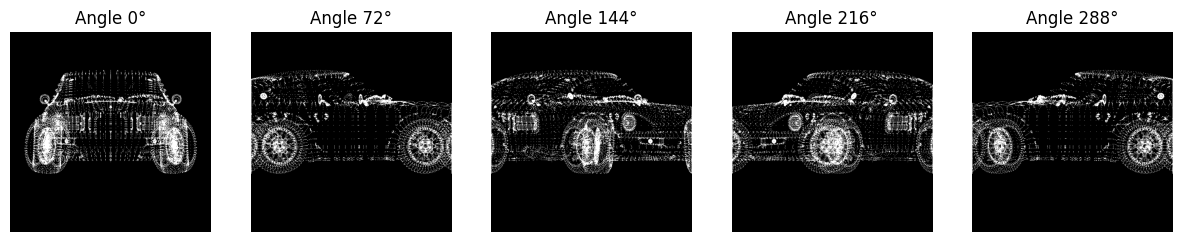

In [50]:
# Render the object from 5 different angles and display these images
W, H = 500, 500
Scale = 250
Shift = [250, 346]
images = []
for angle in range(0, 360, 72):
  angle = angle / 180 * np.pi
  rotated_x = np.cos(angle) * vertices[:, 0] - np.sin(angle) * vertices[:, 2]
  xy = -np.stack([rotated_x, vertices[:, 1]], axis=-1)
  projected_xy = (xy * Scale + Shift).round().astype(int)
  projected_xy = projected_xy.clip(0, [W - 1, H - 1])
  imga = np.zeros((500, 500), dtype=np.uint8)
  imga[projected_xy[:, 1], projected_xy[:, 0]] = 255
  images.append(Image.fromarray(imga))

angles = [0, 72, 144, 216, 288]

plt.figure(figsize=(15, 3))
for i, img in enumerate(images):
  plt.subplot(1, len(images), i + 1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(f"Angle {angles[i]}°")
plt.show()

In [77]:
import cv2 as cv
import time
import ipywidgets as widgets
from IPython.display import display

def rotate_and_project_np(vertices, angle, Scale, Shift, W, H):
  angle = angle / 180 * np.pi
  rotated_x = np.cos(angle) * vertices[:, 0] - np.sin(angle) * vertices[:, 2]
  xy = -np.stack([rotated_x, vertices[:, 1]], axis=-1)
  projected_xy = (xy * Scale + Shift).round().astype(int)
  projected_xy = projected_xy.clip(0, [W - 1, H - 1])
  imga = np.zeros((500, 500), dtype=np.uint8)
  imga[projected_xy[:, 1], projected_xy[:, 0]] = 255
  return imga

img_widget = widgets.Image(format='png', width=W, height=H)
display(img_widget)
numpy_total_time = 0
for angle in np.linspace(0, 360, 1000):
  t0 = time.time()
  imga = rotate_and_project_np(vertices, angle, Scale, Shift, W, H)
  numpy_total_time += time.time() - t0
  img_widget.value = cv.imencode('.png', imga)[1].tobytes()
  time.sleep(0.01)

print("Numpy total time:", numpy_total_time)

Image(value=b'', height='500', width='500')

Numpy total time: 2.0632779598236084


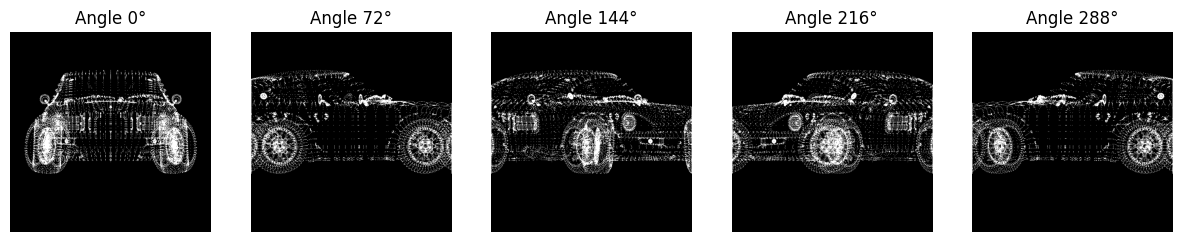

In [70]:
@njit(fastmath=True, parallel=True, nogil=True)
def faster_rotate_and_project_np(vertices, angle, Scale, Shift, W, H):
  angle = angle / 180 * np.pi
  imga = np.zeros((H, W), dtype=np.uint8)
  for i in prange(vertices.shape[0]):
    x, y, z = vertices[i]
    rotated_x = -(np.cos(angle) * x + np.sin(angle) * z)
    ix = int(np.round(rotated_x * Scale + Shift[0]))
    iy = int(np.round(-y * Scale + Shift[1]))
    if 0 <= ix < W and 0 <= iy < H:
      imga[iy, ix] = 255
  return imga

images = []
for angle in range(0, 360, 72):
  angle = angle / 180 * np.pi
  rotated_x = np.cos(angle) * vertices[:, 0] - np.sin(angle) * vertices[:, 2]
  xy = -np.stack([rotated_x, vertices[:, 1]], axis=-1)
  projected_xy = (xy * Scale + Shift).round().astype(int)
  projected_xy = projected_xy.clip(0, [W - 1, H - 1])
  imga = np.zeros((500, 500), dtype=np.uint8)
  imga[projected_xy[:, 1], projected_xy[:, 0]] = 255
  images.append(Image.fromarray(imga))

angles = [0, 72, 144, 216, 288]

plt.figure(figsize=(15, 3))
for i, img in enumerate(images):
  plt.subplot(1, len(images), i + 1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(f"Angle {angles[i]}°")
plt.show()

In [73]:
img_widget = widgets.Image(format='png', width=W, height=H)
display(img_widget)
numba_total_time = 0
for angle in np.linspace(0, 360, 1000):
  t0 = time.time()
  imga = faster_rotate_and_project_np(vertices, angle, Scale, Shift, W, H)
  numba_total_time += time.time() - t0
  img_widget.value = cv.imencode('.png', imga)[1].tobytes()
  time.sleep(0.01)

print("Numba total time:", numba_total_time)

Image(value=b'', height='500', width='500')

Numba total time: 0.14866971969604492


In [78]:
print(f"Numpy time vs Numba time: {numpy_total_time:.6f} vs {numba_total_time:.6f}")
print(f"Numba is {numpy_total_time / numba_total_time:.4f} times faster than Numpy")

Numpy time vs Numba time: 2.063278 vs 0.148670
Numba is 13.8783 times faster than Numpy
